# Ramsey-Cass-Koopmans model

Ramsey model from Chapter 2 of D. Romer's *Advanced Economics* looks as follows...

\begin{align}
    \dot{k}(t) =& k(t)^{\alpha} - c(t) - (g + n + \delta)k(t),\\
    k(0) =& k_0 \\
    \dot{c}(t) =& \Bigg[\frac{1}{\theta} \bigg[\alpha k(t)^{\alpha - 1} - \delta - \rho - \theta g\bigg]\Bigg]c(t),\\
    lim_{t\rightarrow \infty} c(t) =& c^*
\end{align}

...where...

* Elasticity of output with respect to catpial: $0 < \alpha < 1$
* Coefficient of relative risk aversion: $0 < \theta$
* Discount rate: $0 < \rho$
* Breakeven investment: $0 < g + n + \delta$
* Convergent lifetime utility: $0 < \rho - n - (1 - \theta)g$

Note that we are assuming two things...

1. Cobb-Douglas production
2. Constant Relative Risk Aversion (CRRA) preferences



In [128]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import sympy as sym

import pycollocation


In [129]:
# define the variables
t, k , c = sym.symbols("t, k, c")

In [130]:
type(t)

sympy.core.symbol.Symbol

In [131]:
# define some production parameters
alpha, delta = sym.symbols("alpha, delta")

# define growth rates
g, n = sym.symbols("g, n")

# define some preferenece parameters
theta, rho = sym.symbols("theta, rho")

In [132]:
# define a production function
f = k** alpha 

print f

k**alpha


In [133]:
# define a flow of utility function
u = (c**(1 - theta) -1) / (1 - theta)

print u

(c**(-theta + 1) - 1)/(-theta + 1)


In [134]:
# define the equation of motion for capital (per unit effective labor)
k_dot = f - c - (g + n + delta) * k
print k_dot

-c - k*(delta + g + n) + k**alpha


In [135]:
# define the Euler equation
c_dot = ((1 / theta) * (alpha * k ** (alpha - 1) - delta - rho - theta * g))* c 

print c_dot

c*(alpha*k**(alpha - 1) - delta - g*theta - rho)/theta


In [136]:
# create a dictionary representing the RHS of our model 
rhs = {'k' : k_dot, 'c': c_dot}

print rhs

{'k': -c - k*(delta + g + n) + k**alpha, 'c': c*(alpha*k**(alpha - 1) - delta - g*theta - rho)/theta}


In [137]:
# define a steady state value for capital
k_star= (alpha / (delta + rho + theta) * g) ** (1 / (1 - alpha))

print k_star

(alpha*g/(delta + rho + theta))**(1/(-alpha + 1))


..Now we do the same for consumption..
(This is a textcell)

In [138]:
# define a steady state value for capital
c_star= k_star ** alpha - ( g + n + delta) * k_star

print c_star

-(alpha*g/(delta + rho + theta))**(1/(-alpha + 1))*(delta + g + n) + ((alpha*g/(delta + rho + theta))**(1/(-alpha + 1)))**alpha


In [139]:
# define some boundary conditions
k0 = 1.0
bcs = {'lower': [k - k0], 'upper' : [c - c_star] }

print bcs 

{'upper': [c + (alpha*g/(delta + rho + theta))**(1/(-alpha + 1))*(delta + g + n) - ((alpha*g/(delta + rho + theta))**(1/(-alpha + 1)))**alpha], 'lower': [k - 1.0]}


In [140]:
numeric_k_star(**params)

5.084580947867504

In [141]:
# Now we are ready to define some other parameters 
params = {'alpha': 0.33 , 'delta' : 0.04 , 'theta': 1.05, 'rho' : 0.05, 'g' : 0.02, 'n' : 0.02 }

print params

{'g': 0.02, 'delta': 0.04, 'n': 0.02, 'rho': 0.05, 'theta': 1.05, 'alpha': 0.33}


# Using pyCollation

In [142]:
model = pycollocation.SymbolicBoundaryValueProblem(dependent_vars=['k', 'c'],
                                                  independent_var='t',
                                                  rhs=rhs,
                                                  boundary_conditions=bcs,
                                                  params=params)

In [143]:
solver = pycollocation.OrthogonalPolynomialSolver(model)

In [144]:
# numeric version of steady state capital
def numeric_k_star(alpha, delta, theta, rho, g, n) : 
    return (alpha / (delta + rho + theta * g)) ** (1/ (1 - alpha))

In [145]:
# define our domain of approximation
domain = [0.0, 100.0]

N = 1000
ts = np.linspace(domain[0], domain[1], N) 
ks = numeric_k_star(** params) - (numeric_k_star(** params) - k0) * np.exp(-ts)
initial_capital_polynomial = np.polynomial.Chebyshev.fit(ts, ks,  35, domain)

# initial guess for consumption
cs = np.log(ks)
initial_consumption_polynomial = np.polynomial.Chebyshev.fit(ts, cs,  35, domain)

# creat a dictionary of the coefs of our polynomials
initial_guess = { 'k' : initial_capital_polynomial.coef,
                  'c' : initial_consumption_polynomial.coef}

In [146]:
solver.solve = solver. solve(kind="Chebyshev",
                            coefs_dict = initial_guess,
                            domain=domain)
solver.result

  status: 1
 success: True
     qtf: array([ -7.28789085e-11,  -3.47175626e-11,   6.76142099e-11,
         1.20733913e-10,  -8.96096343e-12,   1.19007258e-10,
         5.22511970e-11,  -1.71851433e-11,   1.07924368e-10,
         1.23391589e-10,   1.59421605e-10,   1.69548578e-10,
         2.63002739e-10,  -1.98335375e-10,   3.37835002e-10,
        -1.16276023e-10,  -3.28716385e-10,   5.50598183e-11,
         3.18515046e-10,   5.07022311e-11,  -2.54815163e-10,
        -7.27366232e-11,  -1.80618723e-10,  -1.02017296e-10,
        -1.19251401e-10,  -1.12126157e-10,   4.99560265e-11,
         6.72513747e-11,   3.03041138e-11,   7.98572250e-11,
        -2.16116029e-12,  -3.64021942e-11,   5.13271283e-12,
        -1.07578431e-11,   9.39971833e-12,   2.56217496e-11,
        -4.63117683e-11,   1.67652800e-11,  -2.35727213e-11,
        -4.54269507e-11,  -2.02574072e-11,  -9.50013027e-11,
        -6.35491500e-12,   6.70709584e-11,  -4.44528782e-11,
         6.84435692e-12,  -5.32898674e-11,  -6.3

In [149]:
visualizer = pycollocation.Visualizer(solver)

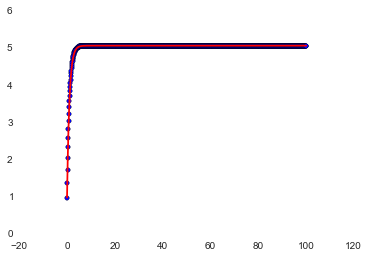

In [150]:
plt.scatter(ts, ks)
plt.plot(ts, initial_capital_polynomial(ts), 'r-')
plt.show()